# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2022spring-ta@googlegroups.com

Slide:    [Link]()　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw8)    
      
**Baseline**
- Simple
    * Sample code
- Medium    0.72895
    * Adjust model structure
- Strong    0.77196
    * Multi-encoder autoencoder
- Boss      0.79506
    * Add random noise and an extra classifier
    * [Papers of anomaly detection](https://github.com/hoya012/awesome-anomaly-detection#anomaly-classification-target)

# Set up the environment


## Package installation

In [1]:
# Training progress bar
!pip install -q qqdm

## Downloading data

- Training data
    * 100000 human faces
- Testing data
    * About 10000 from the same distribution with training data (label 0)
    * About 10000 from another distribution (anomalies, label 1)
- Format
    * data/          
     |----- trainingset.npy          
     |----- testingset.npy
    * Shape: (#images, 64, 64, 3) for each .npy file
        - training data(100000, 64, 64, 3)
        - testing data(19636, 64, 64, 3)


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml2022spring-hw8/data/trainingset.npy
/kaggle/input/ml2022spring-hw8/data/testingset.npy


In [3]:
# !wget https://github.com/MachineLearningHW/HW8_Dataset/releases/download/v1.0.0/data.zip

In [4]:
# !unzip data.zip

# Import packages

In [5]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

# Loading data

In [6]:
train = np.load('/kaggle/input/ml2022spring-hw8/data/trainingset.npy', allow_pickle=True)  # allow_pickle是序列化和反序列化的一个模块，将复杂的对象转换为字节流，以便存储或传输，然后再将字节流还原为对象
test = np.load('/kaggle/input/ml2022spring-hw8/data/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [7]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(48763)

# Autoencoder

# Models & loss

fcn 为避免后续要对输出再操作改变形状，可以直接再decoder中写   
```python      
nn.Linear(1024, 3 * 64 * 64),
            nn.Unflatten(1, (3, 64, 64)),
            nn.Tanh()
        ```        
或者在forward中改变形状    
```python       
def forward(self, x):
        x = x.view(x.size(0), -1)  # 展平输入数据
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 3, 64, 64)  # 重塑输出数据
        return x
    ```

In [8]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        # Medium
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(), 
            nn.Linear(256, 128), 
            nn.ReLU(), 
            nn.Linear(128, 64)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(), 
            nn.Linear(1024, 64 * 64 * 3), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        # Medium
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x     

    
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    # 通过encoder将图像编码为中间表示h1, 再通过enc_out_1和enc_out_2分别输出均值 mu和方差的对数 logvar
    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    # 通过重参数化技巧从以 mu 为中心，标准差为 std 的正态分布中采样潜在变量 z
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_() # 创建一个与 std 形状相同的张量，并从标准正态分布（均值为0，标准差为1）中随机采样。
        eps = torch.Tensor(eps)
        return eps.mul(std).add_(mu) # 将随机噪声 eps 乘以标准差 std，加上均值 mu, 得到从以 mu 为中心，标准差为 std 的正态分布中采样得到潜在变量 z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

In [9]:
class Residual_block(nn.Module):
    def __init__(self, ic, oc, stride=1): # 当传入 stride = 2 时，会把图片长宽缩小一倍
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(ic, oc, stride=stride, padding=1, kernel_size=3), # stride=2: (H,W) -> (H/2, W/2)
            nn.BatchNorm2d(oc),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(oc, oc, stride=1, padding=1, kernel_size=3), # (H,W) -> (H,W)
            nn.BatchNorm2d(oc)
        )
        
        self.downsample = None # 让原来的 x 变成能和 forward(x) 相加的形状，包括 channel 和 (H,W) 都应相同
        if((stride != 1)  or (ic != oc)): # stride != 1 -> (H,W) 变小 ic != oc -> channel 不同 则创建下采样路径
            self.downsample = nn.Sequential(
                nn.Conv2d(ic, oc, stride=stride, kernel_size=1),
                nn.BatchNorm2d(oc)
            )
            
    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        
        if(self.downsample != None):
            residual = self.downsample(residual)
        
        x = x + residual
        x = nn.ReLU(inplace = True)(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block=Residual_block, num_layers = [2, 1, 1, 1]):
        super().__init__()
        self.preconv = nn.Sequential( # 3*64*64 --> 32*64*64
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        def make_residual(block, ic, oc, num_layer, stride=1):
            layers = []
            layers.append(block(ic, oc, stride))
            for i in range(num_layer-1):
                layers.append(block(oc, oc))
            return nn.Sequential(*layers)

        self.layer0 = make_residual(block, ic=32, oc=64, num_layer=num_layers[0], stride=2)
        self.layer1 = make_residual(block, ic=64, oc=128, num_layer=num_layers[1], stride=2)
        self.layer2 = make_residual(block, ic=128, oc=128, num_layer=num_layers[2], stride=2)
        self.layer3 = make_residual(block, ic=128, oc=64, num_layer=num_layers[3], stride=2) 

        self.fc = nn.Sequential(
            nn.Flatten(), # 也可以用 .view(shape[0], -1)
            nn.Dropout(0.2),
            nn.Linear(64*4*4, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace = True)
        )
        
        # 关于 ConvTranspose2d 的介绍：https://blog.csdn.net/qq_36201400/article/details/112604740
        # 大概就是在原图相邻的两个格子之间插 stride-1 个 0（这样原图就会变大了），padding <- kernel-padding-1
        self.decoder = nn.Sequential(
            nn.Linear(64, 64*4*4), # (64) -> (64*4*4)
            nn.BatchNorm1d(64*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)), # (64*4*4) -> (64, 4, 4)
            nn.ConvTranspose2d(64,128,kernel_size=4,stride=2,padding=1), # (64,4,4) -> (128,8,8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,128,kernel_size=4,stride=2,padding=1), # (128,8,8) -> (128,16,16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,128,kernel_size=4,stride=2,padding=1), # (128,16,16) -> (128,32,32)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,3,kernel_size=4,stride=2,padding=1), # (128,32,32) -> (3,64,64)
            nn.Tanh()
        )
    
    def encoder(self, x):
        x = self.preconv(x) # (3,64,64) -> (32,64,64)
        x = self.layer0(x) # (32,64,64) -> (64,32,32) 且通过 resnet(shortcut) 实现，下同
        x = self.layer1(x) # 64*32*32 ->128*16*16
        x = self.layer2(x) # 128*16*16->128*8*8
        x = self.layer3(x) # (128,8,8) -> (64,4,4)
        x = self.fc(x) # (64,4,4) -> (64*4*4) -> (64)
        return x
        
    def forward(self, x): # x : (3, 64, 64)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

```markdown
Resnet
encoder

preconv 3,64,64 -> 32,64,64

Residual最后返回的是两层conv的输出+residual，有downsample时，residual=downsample out，无residual=整个block的input
layer0: make_residual 
	Residual(32,64,stride=2)
		conv1: 32,64,64 -> 64,32,32
		conv2: 64,32,32 -> 64,32,32
		downsample: 32,64,64 -> 64,32,32
	Residual(64,64)
		conv1: 64,32,32 -> 64,32,32
		conv2: 64,32,32 -> 64,32,32
	Residual(64,64)
		conv1: 64,32,32 -> 64,32,32
		conv2: 64,32,32 -> 64,32,32

layer1: make_residual
	Residual(64,128,stride=2)
		conv1: 64,32,32 -> 128,16,16
		conv2: 128,16,16 -> 128,16,16
		downsample: 64,32,32 -> 128,16,16
	Residual(128,128)
		conv1: 128,16,16 -> 128,16,16
		conv2: 128,16,16 -> 128,16,16

layer2: make_residual
	Residual(128,128,stride=2)
		conv1: 128,16,16 -> 128,8,8
		conv2: 128,18,8 -> 128,8,8
		downsample: 128,16,16 -> 128,8,8
	Residual(128,128)
		conv1: 128,8,8 -> 128,8,8
		conv2: 128,8,8 -> 128,8,8

layer3: make_residual
	Residual(128,64,stride=2)
		conv1: 128,8,8 -> 64,4,4
		conv2: 64,4,4 -> 64,4,4
		downsample: 128,8,8 -> 64,4,4
	Residual(64,64)
		conv1: 64,4,4 -> 64,4,4
		conv2: 64,4,4 -> 64,4,4

fc: full-connected
	flatten: 64,4,4 -> 64*4*4
	linear: 64*4*4 -> 64

decoder:

	linear: 64 -> 64*4*4
	unflatten: 64*4*4 -> 64,4,4
	convtranspose: 64,4,4 -> 128,8,8
	convtranspose: 128,8,8 -> 128,16,16
	convtranspose: 128,16,16 -> 128,32,32
	convtranspose: 128,32,32 -> 3,64,64

```

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [10]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        # 输入张量的最后一个维度是3（通常表示RGB图像），则将张量的维度重新排列，从 (N, H, W, C) 转换为 (N, C, H, W)
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)

        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),    # 将图像像素值从 [0, 255] 映射到 [-1.0, 1.0]
        ])

    def __getitem__(self, index):
        x = self.tensors[index]

        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    # 返回数据集的大小，即张量的第一个维度的大小
    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [11]:
print(torch.cuda.is_available())

True


In [12]:
# Training hyperparameters
num_epochs = 100
batch_size = 400 # Medium
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)  # 随机采样数据
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'fcn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': fcn_autoencoder(), 'resnet': ResNet()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## Training loop

In [13]:
# class test:
#     def __init__(self, ic, oc):
#         self.ic = ic
#         self.oc = oc
#         self.hh = [ic, oc]

# hh = test(2, 3)
# aq = *(hh.hh)
# print(aq)

In [14]:
best_loss = np.inf

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list() # 每个 epoch 开始时，tot_loss 被重新初始化为一个空列表
    model.train()
    for data in train_dataloader: # data是一个batch上的

        # ===================loading=====================
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1) # 全连接网络要将img展平为一维向量，从 (batch_size, height, width, channels) 转换为 (batch_size, height * width * channels)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion) # output[0]：重建的图像。img：原始图像。output[1]：潜在变量的均值。output[2]：潜在变量的对数方差。criterion：损失函数
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item()) # tot_loss是一个list, 用于存储当前 epoch 中所有批次的损失值
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)  # 当前epoch上的平均损失
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
        
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss':f'{mean_loss:.5f}'
    })
    
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                               
 0/100          -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 1/100  00:00:10<00:16:54  0.10it/s  1/100  0.16094                             
Description   1.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 2/100  00:00:20<00:16:23  0.10it/s  2/100  0.10074                             
Description   2.0% |█                                                          | Iters    Elapsed Time      Speed    epoch   loss                               
 3/100  00:00:29<00:16:06  0.10it/s  3/100  0.08388                             
Description   3.0% |█                                                          | Iters    Elapsed Time      Spee

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [15]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1) # 也可以用shuffle=True代替sampler
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = f'last_model_{model_type}.pt'
model = torch.load(checkpoint_path)
model.eval()

# prediction file
out_file = 'prediction.csv'

output data shape: torch.Size([3, 12288])


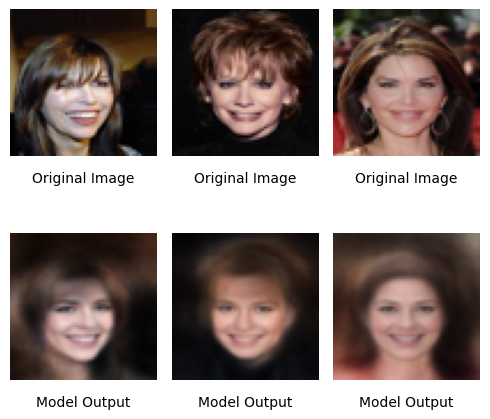

In [16]:
#see picture reconstructed
import matplotlib.pyplot as plt

# 准备输入数据
real_data = train_dataset[:3]  # 从训练集选择前三张图片
real_data = real_data.cuda()
# print(f"input data shape: {real_data.size()}")
if model_type in ['fcn']:
    input_data = real_data.reshape(real_data.size(0), -1)   # 展平输入数据
else:
    input_data = real_data
# 编码和解码
with torch.no_grad():
    decoded_data= model(input_data)
decoded_data = decoded_data.float().cuda()
print(f"output data shape: {decoded_data.size()}")

if model_type in ['fcn']:
    decoded_data = decoded_data.reshape(real_data.size(0), 3, 64, 64)  # 重塑输出数据
elif model_type in ['vae']:
    decoded_data = decoded_data[0]
#print(f"output data shape: {decoded_data.size()}")

# 创建画布
fig, axes = plt.subplots(nrows=2, ncols=len(input_data), figsize=(5, 5)) # 两行三列子图

# 显示原始图像
for idx in range(len(real_data)):
    ax = axes[0][idx]
    ax.imshow(transforms.ToPILImage()((real_data[idx]+1)/2)) # ToPILImage输入是[0,1]
    ax.axis('off')
    ax.annotate('Original Image', xy=(0.5, -0.15), xycoords='axes fraction',ha='center', va='center')
    
# 显示重构图像
for idx in range(len(decoded_data)):
    ax = axes[1][idx]
    ax.imshow(transforms.ToPILImage()((decoded_data[idx]+1)/2))
    ax.axis('off')
    ax.annotate('Model Output', xy=(0.5, -0.15), xycoords='axes fraction',ha='center', va='center')
    
plt.tight_layout()  # 调整子图之间的间距，防止文本被截断
plt.show()

## Question 2   
Train a fully connected autoencoder and adjust at least two different element of the latent representation. Show your model architecture, plot out the original image, the reconstructed images for each adjustment and describe the differences.

sample shape:torch.Size([3, 64, 64])
fcn output shape:torch.Size([1, 12288])
output shape:torch.Size([3, 64, 64])


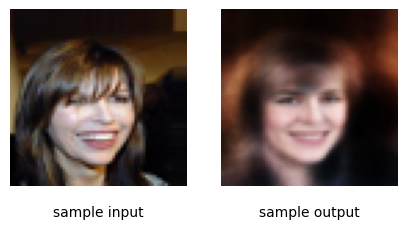

In [17]:
import matplotlib.pyplot as plt
# sample = train_dataset[random.randint(0,100000)]
sample = train_dataset[0]
print("sample shape:{}".format(sample.size()))
sample = sample.reshape(1,3,64,64)

model.eval()
with torch.no_grad():
    img = sample.cuda()
            
    # 只调整fcn中的latent representation的其中两维，其他模型都是正常输出
    if model_type in ['res']:
        output = model(img)
        output = decoder(output)
        print("res output shape:{}".format(output.size()))
        output = output[0] # 第一个重建图像，当然只有一个图像
        
    if model_type in ['fcn']:
        img = img.reshape(img.shape[0], -1)
        x = model.encoder(img)
        x[0][2] = x[0][2]*3
        output = model.decoder(x)
        print("fcn output shape:{}".format(output.size()))
        output = output.reshape(3,64,64)
        
    if model_type in ['vae']:
        output = model(img)
        print("vae output shape:{}".format(output.size()))
        output = output[0][0] # output[0]是重建后的图像，output[0][0]重建后的第一个图像
        
    if model_type in ['cnn']:
        output = model(img)[0]
        
    print("output shape:{}".format(output.size()))
       
sample = sample.reshape(3,64,64)   

# 创建画布
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

# plt sample image
axes[0].imshow(transforms.ToPILImage()((sample+1)/2)) #imshow的输入(H,W,C)
axes[0].axis('off')
axes[0].annotate('sample input', xy=(0.5, -0.15), xycoords='axes fraction',ha='center', va='center')
# plt output image
axes[1].imshow(transforms.ToPILImage()((output+1)/2))
axes[1].axis('off')
axes[1].annotate('sample output', xy=(0.5, -0.15), xycoords='axes fraction',ha='center', va='center')

plt.show()

In [18]:
anomality = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    img = data.float().cuda()
    if model_type in ['fcn']:
      img = img.view(img.shape[0], -1)
    output = model(img)
    if model_type in ['vae']:
      output = output[0]
    if model_type in ['fcn']:
        loss = eval_loss(output, img).sum(-1)
    else:
        loss = eval_loss(output, img).sum([1, 2, 3]) # 在123维度上求和
        
    anomality.append(loss) # 多个批次异常检测结果的列表
    
anomality = torch.cat(anomality, axis=0) # 在第0维度（批次维度）上拼接异常检测的结果，合并成一个大的张量。
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy() # 将张量重塑为形状 (len(test), 1)

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')